In [1]:
%run get_data.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import seaborn as sns
import simfin as sf

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.pipeline import make_pipeline

## Load Merged Dataframes

In [2]:
df_merged_dly_all = pd.read_csv('merged daily data.csv', index_col=[0])

/Users/Daiii/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_merged_dly_all['Weekday'] = df_merged_dly_all['Date'].transform(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').weekday())

In [4]:
df_merged_dly_all

,Sector,Industry,Ticker,Date,Open,Low,High,Close,Adj. Close,Dividend,...,Treasury 1-Year Rate,Treasury 3-Year Rate,Treasury 5-Year Rate,Treasury 10-Year Rate,Treasury 20-Year Rate,Treasury 30-Year Rate,1M-30Y Spread,3M-10Y Spread,3Y-5Y Spread,Weekday
0,Healthcare,Medical Diagnostics & Research,A,2011-08-26,32.64,32.1122,34.9487,34.87,23.23,0.0,...,0.10,0.37,0.98,2.23,3.17,3.60,-3.59,-2.22,-0.61,4
1,Healthcare,Medical Diagnostics & Research,A,2011-08-29,35.44,35.2500,36.8600,36.72,24.46,0.0,...,0.09,0.33,0.94,2.19,3.13,3.54,-3.54,-2.18,-0.61,0
2,Healthcare,Medical Diagnostics & Research,A,2011-08-30,36.48,35.8750,37.0800,36.62,24.39,0.0,...,0.09,0.35,0.99,2.28,3.22,3.63,-3.63,-2.26,-0.64,1
3,Healthcare,Medical Diagnostics & Research,A,2011-08-31,36.76,36.4500,38.0600,36.87,24.56,0.0,...,0.09,0.33,0.94,2.19,3.12,3.53,-3.52,-2.18,-0.61,2
4,Healthcare,Medical Diagnostics & Research,A,2011-09-01,36.80,35.6700,37.3500,35.84,23.87,0.0,...,0.10,0.33,0.96,2.23,3.19,3.60,-3.59,-2.21,-0.63,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891058,Consumer Cyclical,Retail - Apparel & Specialty,low,2020-05-08,113.77,112.1000,114.6300,114.23,114.23,0.0,...,0.15,0.19,0.29,0.63,1.05,1.31,-1.21,-0.52,-0.10,4
2891059,Consumer Cyclical,Retail - Apparel & Specialty,low,2020-05-11,113.10,112.5733,114.7500,113.39,113.39,0.0,...,0.15,0.21,0.33,0.69,1.12,1.39,-1.29,-0.57,-0.12,0
2891060,Consumer Cyclical,Retail - Apparel & Specialty,low,2020-05-12,114.82,111.1800,115.0500,111.24,111.24,0.0,...,0.16,0.24,0.36,0.73,1.16,1.43,-1.34,-0.61,-0.12,1
2891061,Consumer Cyclical,Retail - Apparel & Specialty,low,2020-05-13,111.89,108.8100,113.3900,110.43,110.43,0.0,...,0.16,0.22,0.34,0.69,1.11,1.38,-1.28,-0.56,-0.12,2


## Predicting DOD/WOW return using technical signals and macro indicators

### Split the data into train and test sets

In [5]:
features = \
['x0_Basic Materials', 'x0_Business Services', 'x0_Consumer Cyclical', 
 'x0_Consumer Defensive', 'x0_Energy', 'x0_Financial Services', 'x0_Healthcare', 
 'x0_Industrials', 'x0_Other', 'x0_Real Estate', 'x0_Technology', 'x0_Utilities', 
 'Dividend Yield', 'Earnings Yield', 'FCF Yield', 'Market-Cap', 'P/Book', 'P/Cash', 
 'P/E', 'P/FCF', 'P/NCAV', 'P/NetNet', 'P/Sales', 'Relative Volume', 'Volume Market-Cap', 
 'Volume Turnover', '%D14', '%D5', '%K 14', '%K 5', 'ATR 1', 'ATR 10', 'ATR 15', 'ATR 2', 
 'ATR 3', 'ATR 4', 'ATR 5', 'EMA 12', 'EMA 26', 'LowerBB 26', 'MA 20', 'MA 50', 'MACD', 
 'MACD_EMA', 'MOM 1', 'MOM 10', 'MOM 15', 'MOM 2', 'MOM 3', 'MOM 4', 'MOM 5', 
 'MiddleBB26', 'ROC 1', 'ROC 10', 'ROC 15', 'ROC 2', 'ROC 3', 'ROC 4', 'ROC 5', 
 'TRIX 12', 'UppwerBB 26', 'MA Buy', 'MA Sell', 'MACD Buy', 'MACD Sell', 'RSI', 
 'RSI_VALUE_BUY', 'SHORT_TERM_RSI', 'LONG_TERM_RSI', 'RSI_BUY', 'Treasury 1-Month Rate', 
 'Treasury 3-Month Rate', 'Treasury 6-Month Rate', 'Treasury 1-Year Rate', 
 'Treasury 3-Year Rate', 'Treasury 5-Year Rate', 'Treasury 10-Year Rate', 
 'Treasury 20-Year Rate', 'Treasury 30-Year Rate', '1M-30Y Spread', '3M-10Y Spread', 
 '3Y-5Y Spread', 'Weekday']

In [6]:
with open('S&P 500 tickers.txt', 'r') as file:
    tickers = file.readlines()
tickers = [x.strip() for x in tickers]
print('Total stocks in S&P 500 index:   ', len(tickers))
tickers = list(set(df_merged_dly_all.Ticker).intersection(tickers))
print('Number of chosen stocks:         ', len(tickers))

Total stocks in S&P 500 index:    505
Number of chosen stocks:          418


In [7]:
df_merged_dly = df_merged_dly_all[df_merged_dly_all.Ticker.isin(tickers)]

df_train = df_merged_dly[df_merged_dly['Date'] < '2018-01-01'].reset_index(drop=True)
df_test = df_merged_dly[(df_merged_dly['Date'] >= '2018-01-01') & (df_merged_dly['Date'] < '2020-01-01')].reset_index(drop=True)

train = df_train[features]
y_train_ret = df_train['Return T+5']
y_train_mov = df_train['Moveup T+5']

test = df_test[features]
y_test_ret = df_test['Return T+5']
y_test_mov = df_test['Moveup T+5']

print('Train:', df_train['Date'].min(), 'to',df_train['Date'].max())
print('X train:', train.shape)
print('y train:', y_train_ret.shape)
print()

print('Test:', df_test['Date'].min(), 'to',df_test['Date'].max())
print('X test:', test.shape)
print('y test:', y_test_ret.shape)

Train: 2009-09-28 to 2017-12-29
X train: (620036, 83)
y train: (620036,)

Test: 2018-01-02 to 2019-12-31
X test: (202974, 83)
y test: (202974,)


### Define a Cross-Validation Strategy

In [8]:
def precision_cv(n_folds, model, X, y):
    kf = KFold(n_folds, shuffle=False).get_n_splits(X.values)
    scores = cross_validate(model, X, y, cv=kf, scoring='precision', return_train_score=True, n_jobs=-1)
    return scores['train_score'], scores['test_score']

In [9]:
print('Baseline score (train set): {:.4f}'.format(sum(y_train_mov == 1) / len(y_train_mov)))

Baseline score (train set): 0.5517


### Back Testing: random forest with max depth = 25

In [12]:
rf = RandomForestClassifier(max_depth=25, random_state=0, n_estimators=100, n_jobs=-1)
rf.fit(train, y_train_mov)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
risk_free_interest_rate = 0.03

In [14]:
thresholds = []
precisions = []
returns = []
volatilities = []
sharpe_ratios = []
holdings = []
for threshold in np.arange(0.5, 1.01, 0.01):
    y_pred = (pd.DataFrame(rf.predict_proba(test)).iloc[:,1] > threshold).astype(int)
    precision = precision_score(y_true=y_test_mov, y_pred=y_pred)
    return_qrt = y_test_ret[y_pred == 1].mean()
    std_qrt = y_test_ret[y_pred == 1].std()
    if sum(y_pred == 1) > 100:
        thresholds.append(threshold)
        precisions.append(precision*100)
        returns.append(return_qrt*52*100)
        volatilities.append(std_qrt*np.sqrt(52)*100)
        sharpe_ratios.append((return_qrt*52 - risk_free_interest_rate)/(std_qrt*np.sqrt(52)))
        holdings.append(sum(y_pred == 1))
    else:
        break

In [15]:
df_thresholds = pd.DataFrame({'Threshold': thresholds,
                             'Precision': precisions,
                             'Annualized Return': returns,
                             'Annualized Volatility': volatilities,
                             'Annualized Sharpe Ratio': sharpe_ratios,
                             'Number of Holding Stocks': holdings})
df_thresholds

,Threshold,Precision,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Number of Holding Stocks
0,0.50,55.033188,11.695307,28.661938,0.303375,154425
1,0.51,55.125274,11.926010,28.673592,0.311297,146080
2,0.52,55.238868,12.318552,28.746598,0.324162,136833
3,0.53,55.325197,12.566225,28.770003,0.332507,127000
4,0.54,55.403599,12.696394,28.821879,0.336425,116700
5,0.55,55.498172,12.939537,28.863976,0.344358,106108
6,0.56,55.545073,13.153357,28.904270,0.351275,95400
7,0.57,55.688877,13.451828,28.872651,0.361998,84841
8,0.58,55.755217,13.554640,28.861980,0.365694,74515
9,0.59,55.931915,14.235375,28.778998,0.390402,64684


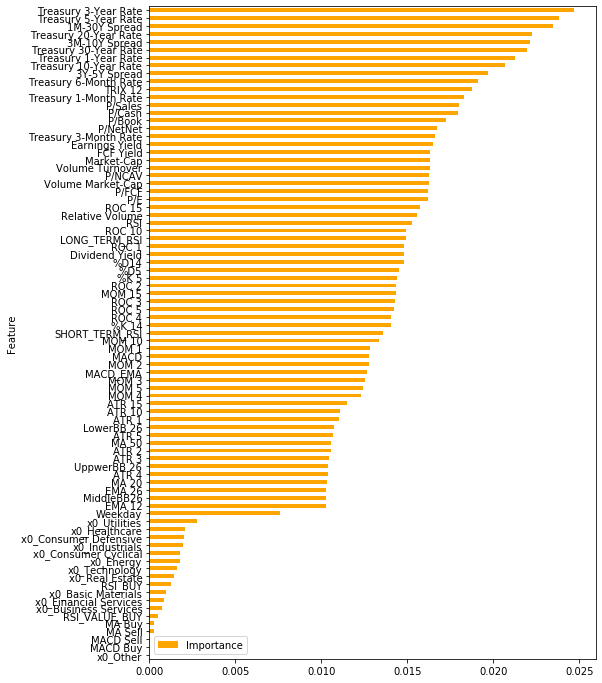

In [16]:
# Show importance of the featuresa
importance_frame = pd.DataFrame({'Importance': list(rf.feature_importances_), 'Feature': list(train.columns)})
importance_frame.sort_values(by='Importance', inplace=True)
importance_frame.plot(kind='barh', x='Feature', figsize=(8, 12), color='orange')

In [19]:
# baseline
base_precision = precision_score(y_true=y_test_mov, y_pred=np.ones(len(test)))*100
base_return = y_test_ret.mean()*52*100
base_volatility = y_test_ret.std()*np.sqrt(52)*100
base_sharpe_ratio = (base_return - risk_free_interest_rate*100)/(base_volatility)
print(base_precision, base_return, base_volatility, base_sharpe_ratio)


54.72868446204933 10.151877826644299 28.138718672862467 0.2541650140431487


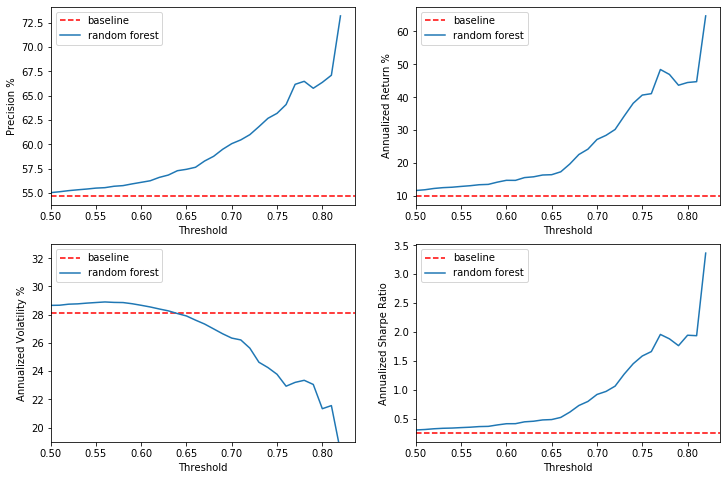

In [20]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].axhline(y=base_precision, color='r', label='baseline', linestyle='--')
axs[0,0].plot(df_thresholds['Threshold'], df_thresholds['Precision'], label='random forest')
axs[0,0].set_ylabel('Precision %')
axs[0,0].set_xlabel('Threshold')

axs[0,1].axhline(y=base_return, color='r', label='baseline', linestyle='--')
axs[0,1].plot(df_thresholds['Threshold'], df_thresholds['Annualized Return'],label='random forest')
axs[0,1].set_ylabel('Annualized Return %')
axs[0,1].set_xlabel('Threshold')

axs[1,0].axhline(y=base_volatility, color='r', label='baseline', linestyle='--')
axs[1,0].plot(df_thresholds['Threshold'], df_thresholds['Annualized Volatility'], label='random forest')
axs[1,0].set_ylabel('Annualized Volatility %')
axs[1,0].set_xlabel('Threshold')
axs[1,0].set_ylim((19,33))

axs[1,1].axhline(y=base_sharpe_ratio, color='r', label='baseline', linestyle='--')
axs[1,1].plot(df_thresholds['Threshold'], df_thresholds['Annualized Sharpe Ratio'], label='random forest')
axs[1,1].set_ylabel('Annualized Sharpe Ratio')
axs[1,1].set_xlabel('Threshold')

for row in axs:
    for ax in row:
        ax.legend(loc='upper left')
        ax.set_xlim((0.5))

In [21]:
df_merged_prob = df_test.copy()
df_merged_prob['Prob'] = [float(x[1]) for x in rf.predict_proba(test)]
df_merged_prob = df_merged_prob.sort_values(by='Date').reset_index(drop=True)

In [22]:
df_merged_prob[['Ticker', 'Date', 'Return T+5', 'Prob']]

,Ticker,Date,Return T+5,Prob
0,A,2018-01-02,0.061686,0.708998
1,CTSH,2018-01-02,0.035377,0.748328
2,BWA,2018-01-02,0.076477,0.693390
3,REGN,2018-01-02,-0.036461,0.610916
4,MRO,2018-01-02,0.038550,0.779038
...,...,...,...,...
202969,CERN,2019-12-31,0.000749,0.554626
202970,PH,2019-12-31,0.003935,0.621388
202971,PG,2019-12-31,-0.019135,0.540704
202972,PKI,2019-12-31,0.015345,0.604896


In [23]:
df_merged_prob = df_test.copy()
df_merged_prob['Prob'] = [float(x[1]) for x in rf.predict_proba(test)]
df_merged_prob= df_merged_prob.sort_values(by='Date')

print(df_merged_prob['Date'].iloc[0], df_merged_prob['Date'].iloc[-1])

from datetime import datetime
datetimes = pd.DataFrame({'Date':pd.date_range(start='2018-01-01', end='2020-01-01', freq='D')})
datetimes['Date'] = datetimes['Date'].transform(lambda x: x.strftime('%Y-%m-%d'))

2018-01-02 2019-12-31


In [24]:
datetimes

,Date
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
726,2019-12-28
727,2019-12-29
728,2019-12-30
729,2019-12-31


Text(0, 0.5, 'Cumulative Returns')

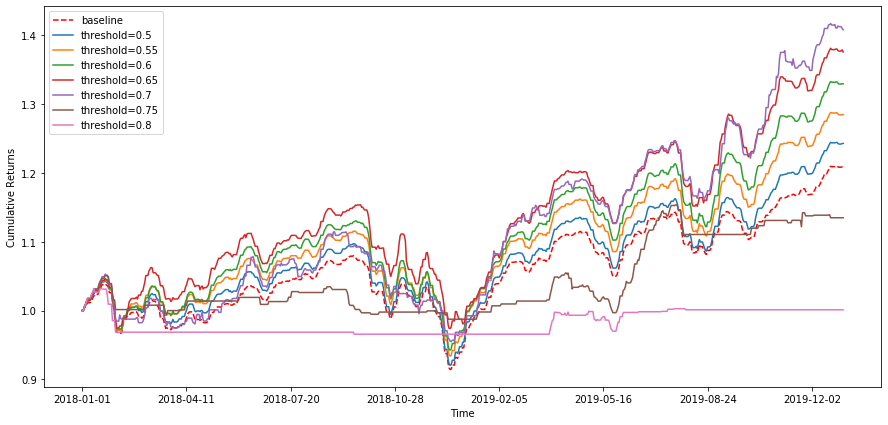

In [25]:
group_1 = df_merged_prob[df_merged_prob.Weekday == 0].reset_index(drop=True)
group_2 = df_merged_prob[df_merged_prob.Weekday == 1].reset_index(drop=True)
group_3 = df_merged_prob[df_merged_prob.Weekday == 2].reset_index(drop=True)
group_4 = df_merged_prob[df_merged_prob.Weekday == 3].reset_index(drop=True)
group_5 = df_merged_prob[df_merged_prob.Weekday == 4].reset_index(drop=True)


fig, ax = plt.subplots(1,1, figsize=(15,7))

#baseline
df_1 = group_1.groupby('Date').mean()
df_1 = pd.merge(left = datetimes, right = df_1[['Return T+5', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

df_2 = group_2.groupby('Date').mean()
df_2 = pd.merge(left = datetimes, right = df_2[['Return T+5', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

df_3 = group_3.groupby('Date').mean()
df_3 = pd.merge(left = datetimes, right = df_3[['Return T+5', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

df_4 = group_4.groupby('Date').mean()
df_4 = pd.merge(left = datetimes, right = df_4[['Return T+5', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)


df_5 = group_5.groupby('Date').mean()
df_5 = pd.merge(left = datetimes, right = df_5[['Return T+5', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

_y = [1]
_y.extend([1+x for x in pd.concat([df_1, df_2, df_3, df_4, df_5],axis=1)[['Return T+5']].mean(axis=1)][:-1])
ax.plot(datetimes['Date'],
        np.cumprod(_y), 
        label='baseline', color='r', linestyle='--')


for threshold in np.arange(thresholds[0], thresholds[-1]+0.001, 0.05):
    df_1 = group_1[group_1['Prob'] > threshold].groupby('Date').mean()
    df_1 = pd.merge(left = datetimes, right = df_1[['Return T+5', 'Prob']],
                          left_on='Date', right_index=True, how = 'left').fillna(0)

    df_2 = group_2[group_2['Prob'] > threshold].groupby('Date').mean()
    df_2 = pd.merge(left = datetimes, right = df_2[['Return T+5', 'Prob']],
                          left_on='Date', right_index=True, how = 'left').fillna(0)

    df_3 = group_3[group_3['Prob'] > threshold].groupby('Date').mean()
    df_3 = pd.merge(left = datetimes, right = df_3[['Return T+5', 'Prob']],
                          left_on='Date', right_index=True, how = 'left').fillna(0)

    df_4 = group_4[group_4['Prob'] > threshold].groupby('Date').mean()
    df_4 = pd.merge(left = datetimes, right = df_4[['Return T+5', 'Prob']],
                          left_on='Date', right_index=True, how = 'left').fillna(0)


    df_5 = group_5[group_5['Prob'] > threshold].groupby('Date').mean()
    df_5 = pd.merge(left = datetimes, right = df_5[['Return T+5', 'Prob']],
                          left_on='Date', right_index=True, how = 'left').fillna(0)
    
    
    _y = [1]
    _y.extend([1+x for x in pd.concat([df_1, df_2, df_3, df_4, df_5],axis=1)[['Return T+5']].mean(axis=1)][:-1])
    ax.plot(datetimes['Date'],
            np.cumprod(_y), 
            label='threshold='+str(round(threshold,2)))

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Returns')